In [1]:
# Testing the Basic Python implementation of wordfish

In [2]:
import numpy as np
import pandas as pd

from wordfish import Wordfish

import warnings
warnings.simplefilter('ignore')

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(quanteda)
library(quanteda.textmodels)
library(quanteda.textstats)

library(tidyverse)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Package version: 4.3.1
Unicode version: 14.0
ICU version: 70.1
Parallel computing: 8 of 8 threads used.
See https://quanteda.io for tutorials and examples.


In [5]:
%%R
preprocess_ys <- function(ys, remove_stopwords=TRUE, stem=TRUE, min_docfreq = 3, max_docfreq = 0.8) {
  corpus <- corpus(ys, text_field = 'body')
  
  toks <- corpus %>% 
    tokens(remove_punct = TRUE) %>% 
    tokens_tolower()

  if (stem) {
    tok <- toks %>% 
      tokens_wordstem()
  }
  
  if (remove_stopwords) {
    toks <- toks %>% 
      tokens_remove(stopwords('english'))  
  }

  mx <- toks %>% 
    dfm() %>% 
    dfm_trim(min_docfreq = min_docfreq, max_docfreq = as.integer(ndoc(corpus) * max_docfreq))

  return(mx)
}

In [6]:
%%R
load("../data/YoungSoroka.2012.Rdata")

### 全体
ys <- YS %>% 
  as_tibble() %>% 
  mutate(is_pos_1 = if_else(code_1 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_1 = if_else(code_1 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_2 = if_else(code_2 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_2 = if_else(code_2 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_3 = if_else(code_3 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_3 = if_else(code_3 == 'Negative', TRUE, FALSE)) %>% 
  mutate(n_pos = is_pos_1 + is_pos_2 + is_pos_3) %>% 
  mutate(n_neg = is_neg_1 + is_neg_2 + is_neg_3) %>%
  mutate(scale = if_else(n_pos == 3, 5, if_else(n_pos ==2, 4, if_else(n_neg == 2, 2, if_else(n_neg == 3, 1, 3)))))

In [7]:
%%R
ys_economy <- ys %>%
  filter(topic == 'Economy')
mx_economy <- preprocess_ys(ys_economy, remove_stopwords = TRUE, stem = FALSE, min_docfreq = 10, max_docfreq = 0.8)
wf_economy <- textmodel_wordfish(mx_economy, dir = c(2, 1))
smr_economy <- summary(wf_economy)
ys_economy <- ys_economy %>% 
  add_column(theta = smr_economy$estimated.document.positions$theta)
g_economy <- ggplot(data = ys_economy, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot() +
  geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
  labs(title = paste("wordfish - economy", " (", cor(ys_economy$scale, ys_economy$theta, method="pearson"), ")"),
       x = "ometa",
       y = "human")

ys_foreign <- ys %>%
  filter(topic == 'Foreign')
mx_foreign <- preprocess_ys(ys_foreign, remove_stopwords = TRUE, stem = FALSE, min_docfreq = 10, max_docfreq = 0.8)
wf <- textmodel_wordfish(mx_foreign, dir = c(2, 1))
smr <- summary(wf)
ys_foreign <- ys_foreign %>% 
  add_column(theta = smr$estimated.document.positions$theta)
g_foreign <- ggplot(data = ys_foreign, mapping = aes(x = theta, y = scale, group = scale)) +
  geom_boxplot() +
  geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
  labs(title = paste("wordfish - foreign", " (", cor <- cor(ys_foreign$scale, ys_foreign$theta, method="pearson"), ")"),
       x = "ometa",
       y = "human")

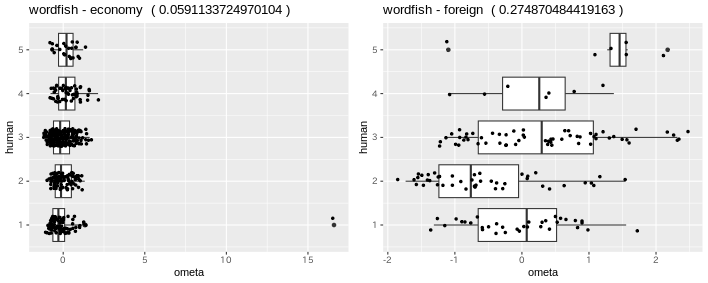

In [8]:
%%R -w 25 -h 10 --units cm
gridExtra::grid.arrange(g_economy, g_foreign, ncol = 2)

In [9]:
%%R
df_economy <- convert(mx_economy, to = "data.frame")
df_economy <- as_tibble(rownames_to_column(df_economy, "Id"))

df_foreign <- convert(mx_foreign, to = "data.frame")
df_foreign <- as_tibble(rownames_to_column(df_foreign, "Id"))

In [10]:
%R -o df_economy,df_foreign

In [11]:
# economy
word_doc_matrix = df_economy.iloc[:, 2:].values
doc_names = df_economy["doc_id"].tolist()
word_names = df_economy.columns[2:].tolist()

results = Wordfish().fit(
    word_doc_matrix,
    dir_docs=(1, 2),
## direction differ from R implementation 
#    dir_docs=(2, 1),
    doc_names=doc_names,
    word_names=word_names,
)

omega_economy = results.documents[:, 0]

# foreign
word_doc_matrix = df_foreign.iloc[:, 2:].values
doc_names = df_foreign["doc_id"].tolist()
word_names = df_foreign.columns[2:].tolist()

results = Wordfish().fit(
    word_doc_matrix,
    dir_docs=(1, 2),
## direction differ from R implementation 
#    dir_docs=(2, 1),
    doc_names=doc_names,
    word_names=word_names,
)

omega_foreign = results.documents[:, 0]

WORDFISH (Python Implementation)
Number of unique words: 1804
Number of documents: 450
Tolerance criterion: 1e-07
Identification: Omegas identified with mean 0, st.dev. 1
Performing mean 0 sd 1 starting value calc
Performing mean 0 sd 1 EM algorithm
Iteration 1
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 500.0
Iteration 2
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 0.02235800124811089
Iteration 3
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 0.00504345419028778
Iteration 4
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 0.001707904258979534
Iteration 5
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 0.0005817431798385296
Iteration 6
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 0.0001867037442691289
Iteration 7
	Updating alpha and omega..
	Updating psi and beta..
	Convergence of LL: 6.404906399025088e-05
Iteration 8
	Updating 

In [12]:
%%R -i omega_economy,omega_foreign
data <- tibble(
    scale = ys_economy$scale,
    omega = omega_economy
)
g_economy <- ggplot(data = data, mapping = aes(x = omega, y = scale, group = scale)) +
  geom_boxplot(outlier.colour = NA) +
  geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
  labs(title = paste("wordfish - economy", " (", round(cor(ys_economy$scale, omega_economy, method="pearson"), digits = 3), ")"),
       x = "omega",
       y = "human")

data <- tibble(
    scale = ys_foreign$scale,
    omega = omega_foreign
)
g_foreign <- ggplot(data = data, mapping = aes(x = omega, y = scale, group = scale)) +
  geom_boxplot(outlier.colour = NA) +
  geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
  labs(title = paste("wordfish - economy", " (", round(cor(data$scale, data$omega, method="pearson"), digits = 3), ")"),
       x = "omega",
       y = "human")

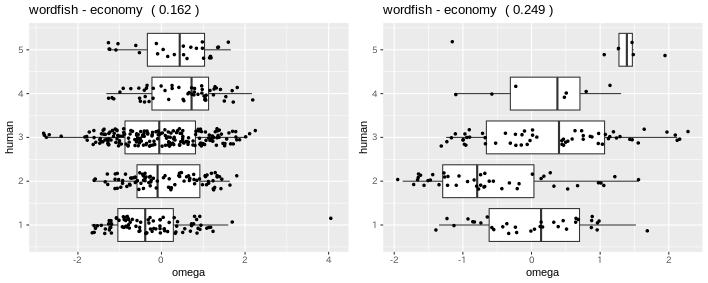

In [13]:
%%R -w 25 -h 10 --units cm
gridExtra::grid.arrange(g_economy, g_foreign, ncol = 2)